# DATA EXPLORATION

In [3]:
# data download
%cd geonwooko
# !wget https://raw.githubusercontent.com/vibhor98/German-Credit-Dataset/refs/heads/master/german_credit_data.csv -O data/german_credit_data.csv

/Users/ko/Documents/Study/pyspark/spark-study/geonwooko


/Users/ko/Documents/Study/pyspark/spark-study/.venv/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## 7.1 Univariate Analysis

In [6]:
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder.appName("Python Spark Data Exploration")
    .config("spark.some.config.option", "some-value")
    .getOrCreate()
)

In [9]:
df = (
    spark.read.format("com.databricks.spark.csv")
    .options(header="true", inferschema="true")
    .load("geonwooko/data/german_credit_data.csv", header=True)
)

df.columns

['_c0',
 'Age',
 'Sex',
 'Job',
 'Housing',
 'Saving accounts',
 'Checking account',
 'Credit amount',
 'Duration',
 'Purpose']

In [10]:
df.show(5)

+---+---+------+---+-------+---------------+----------------+-------------+--------+-------------------+
|_c0|Age|   Sex|Job|Housing|Saving accounts|Checking account|Credit amount|Duration|            Purpose|
+---+---+------+---+-------+---------------+----------------+-------------+--------+-------------------+
|  0| 67|  male|  2|      3|             NA|          little|         1169|       6|           radio/TV|
|  1| 22|female|  2|      3|         little|        moderate|         5951|      48|           radio/TV|
|  2| 49|  male|  1|      3|         little|              NA|         2096|      12|          education|
|  3| 45|  male|  2|      2|         little|          little|         7882|      42|furniture/equipment|
|  4| 53|  male|  2|      2|         little|          little|         4870|      24|                car|
+---+---+------+---+-------+---------------+----------------+-------------+--------+-------------------+
only showing top 5 rows



25/08/31 10:17:05 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Age, Sex, Job, Housing, Saving accounts, Checking account, Credit amount, Duration, Purpose
 Schema: _c0, Age, Sex, Job, Housing, Saving accounts, Checking account, Credit amount, Duration, Purpose
Expected: _c0 but found: 
CSV file: file:///Users/ko/Documents/Study/pyspark/spark-study/geonwooko/data/german_credit_data.csv


### 7.1.1 Numerical Variables

pandas와 비슷한 방법으로 EDA를 진행할 수 있다.


In [6]:
num_cols = ["Credit amount", "Duration"]

# base statistics
df.select(num_cols).describe().show()

# pyspark에서는 기본적으로 describe에서 quartile을 보여주지 않는다.

+-------+-----------------+------------------+
|summary|    Credit amount|          Duration|
+-------+-----------------+------------------+
|  count|             1000|              1000|
|   mean|         3271.258|            20.903|
| stddev|2822.736875960441|12.058814452756371|
|    min|              250|                 4|
|    max|            18424|                72|
+-------+-----------------+------------------+



In [7]:
from pyspark.sql.functions import col, skewness, kurtosis

# 왜도와 첨도
# 왜도의 경우 양수값을 가지면, 좌측으로 꼬리를 가진 분포임.
# 첨도의 경우 값이 클 수록, 최빈값에 대한 density가 높음.
df.select(skewness(col("Credit amount")), kurtosis(col("Credit amount"))).show()

+-----------------------+-----------------------+
|skewness(Credit amount)|kurtosis(Credit amount)|
+-----------------------+-----------------------+
|     1.9467020189419213|      4.265163377213482|
+-----------------------+-----------------------+



Matplotlib is building the font cache; this may take a moment.
/var/folders/3y/bjq5fmmd3cld60g9nkdd_jkm0000gn/T/ipykernel_2240/162853253.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)  # plt.text(-0.6, -1.4,'0')plt.xlabel(var)


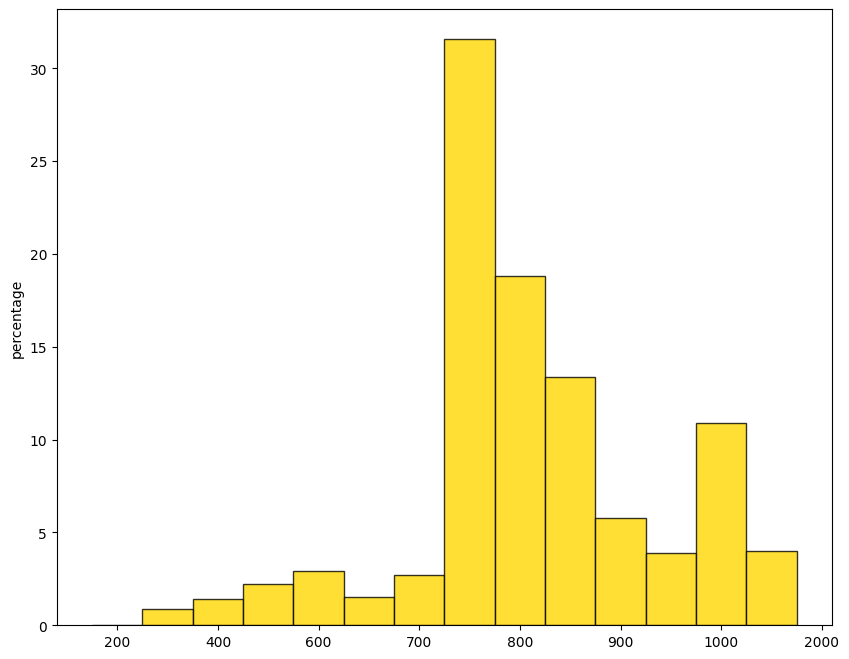

In [8]:
import matplotlib.pyplot as plt
import numpy as np

var = "Credit amount"
# 시각화를 위해선 메모리에 데이터를 올려야 한다.
# 메모리 최적화를 위해 요약된 데이터를 사용하거나, sample을 이용해 적정량의 데이터만 활용하는게 좋다.
x = df.select(var).toPandas()[var]
bins = [
    0,
    200,
    400,
    600,
    700,
    800,
    900,
    1000,
    2000,
    3000,
    4000,
    5000,
    6000,
    10000,
    25000,
]
hist, bin_edges = np.histogram(
    x, bins, weights=np.zeros_like(x) + 100.0 / x.size
)  # make the histogram
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(
    1, 1, 1
)  # Plot the histogram heights against integers on the x axis

ax.bar(
    range(len(hist)), hist, width=1, alpha=0.8, ec="black", color="gold"
)  # # Set the ticks to the middle of the barsax.set_xticks([0.5+i for i,j in enumerate(hist)])# Set the xticklabels to a string that tells us what the bin edges were
# labels =['{}k'.format(int(bins[i+1]/1000)) for i,j in enumerate(hist)]
labels = ["{}".format(bins[i + 1]) for i, j in enumerate(hist)]
labels.insert(0, "0")
ax.set_xticklabels(labels)  # plt.text(-0.6, -1.4,'0')plt.xlabel(var)
plt.ylabel("percentage")
plt.show()

### 7.1.2 Categorical Variables

그룹별 빈도수 계산하기

In [9]:
from pyspark.sql import functions as F
from pyspark.sql.functions import rank, sum, col
from pyspark.sql import Window


# unboundedPreceding: 현재 행 이전의 모든 행을 포함
# unboundedFollowing: 현재 행 이후의 모든 행을 포함
window = Window.rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)


tab = (
    df.select(["Age", "Credit amount"])
    .withColumn("age_class", (col("Age") / 10).cast("int"))
    .groupBy("age_class")
    .agg(
        F.count("Credit amount").alias("count"),
        F.mean("Credit amount").alias("mean"),
        F.stddev("Credit amount").alias("stddev"),
        F.min("Credit amount").alias("min"),
        F.max("Credit amount").alias("max"),
    )
    .withColumn(
        "total", sum(col("count")).over(window)
    )  # 전체 row(count)에 대한 sum을 한 후
    .withColumn("Percent", col("count") / col("total"))  # 각 그룹의 비율을 계산
    .drop(col("total"))
)

tab.show()

25/08/23 23:06:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/23 23:06:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/23 23:06:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/23 23:06:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/23 23:06:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+---------+-----+------------------+------------------+----+-----+-------+
|age_class|count|              mean|            stddev| min|  max|Percent|
+---------+-----+------------------+------------------+----+-----+-------+
|        1|    2|            1481.5| 704.9854608429879| 983| 1980|  0.002|
|        6|   44| 3169.568181818182| 3534.153156008784| 571|14896|  0.044|
|        3|  330|3404.2606060606063|2805.3544881562616| 368|18424|   0.33|
|        5|   74|3248.3783783783783|3004.6199253756636| 338|15945|  0.074|
|        4|  174|3404.0057471264367|2870.9334577871928| 250|15857|  0.174|
|        7|    7| 4242.714285714285| 2359.944046955755|1299| 7308|  0.007|
|        2|  369|  3097.70189701897| 2699.228403842572| 276|15672|  0.369|
+---------+-----+------------------+------------------+----+-----+-------+



25/08/23 23:06:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/23 23:06:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Draw pie plot

25/08/23 23:06:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/23 23:06:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/23 23:06:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/23 23:06:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/23 23:06:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/23 23:06:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/23 2

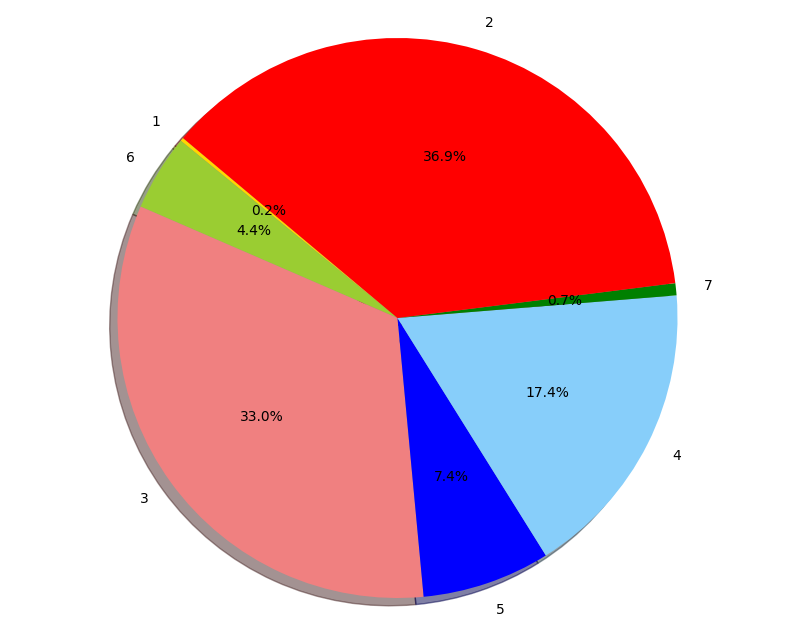

In [10]:
import matplotlib.pyplot as plt

# Data to plot
labels = tab.select("age_class").toPandas()["age_class"]
sizes = tab.select("Percent").toPandas()["Percent"]
colors = ["gold", "yellowgreen", "lightcoral", "blue", "lightskyblue", "green", "red"]

plt.figure(figsize=(10, 8))
plt.pie(
    sizes,
    labels=labels,
    colors=colors,
    autopct="%1.1f%%",
    shadow=True,
    startangle=140,
)
plt.axis("equal")

plt.show()

## 7.2 Multivariate Analysis

### 7.2.1 Numerical V.S. Numerical

Correlation Plot

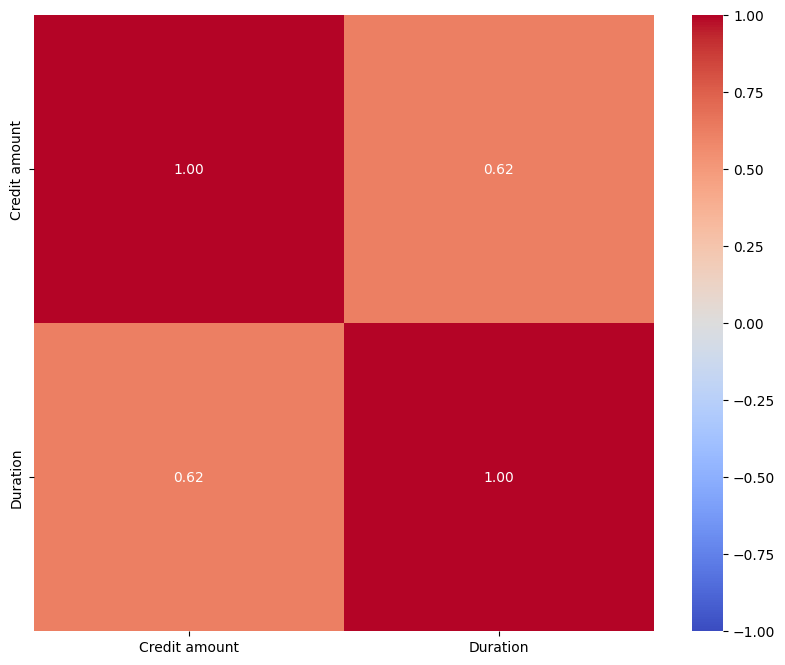

In [ ]:
# correlation matrix
# from pyspark.mllib.stat import Statistics
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import seaborn as sns
import matplotlib.pyplot as plt

num_cols = ["Credit amount", "Duration"]
corr_data = df.select(num_cols)

col_names = corr_data.columns
# mllib은 구버전의 rdd만 지원하므로, 데이터프레임을 rdd로 변환해야함.
# RDD의 각 Row 객체를 벡터 형태로 변환하기 위해 map 사용
# Statistics.corr()는 RDD[Vector] 형태의 데이터를 요구하므로 모든 값을 슬라이싱 하여 벡터로 변환
features = VectorAssembler(inputCols=col_names, outputCol="features").transform(
    corr_data
)

# 상관관게 계산
corr_mat = Correlation.corr(features, "features", method="pearson").collect()[0][0]

# 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(corr_mat.toArray(), annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
ax = plt.gca()
ax.set_xticklabels(col_names)
ax.set_yticklabels(col_names)
plt.show()

###  Pearson's Chi-squared test
[refs](https://m.blog.naver.com/gksshdk8003/222305638201)

카이제곱검정은 크게 세 가지 경우에서 사용된다.
1. 적합도 검정: 변수가 특정 분포를 따르는지 확인하고 싶은 경우 
2. 동질성 검정: 두 개 이상의 모집단에서 하나의 변수의 분포가 동일한지 검정 (e.g., 남성/여성 모집단에서 각 표본을 추출하여 좋아하는 음료 분포가 동일한지)
3. 독립성 검정: 하나의 모집단에서 두 개의 범주형 변수가 서로 연관성이 있는지/독립인지 검정 (e.g., 한 고등학교 학생들 중 성별과 좋아하는 과목 간에 연관성이 있는지 확인) 

In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import ChiSquareTest

# 동질성 검정, x=dense vector, y=0 or 1
dataset = [
    [0, Vectors.dense([0, 0, 1])],
    [0, Vectors.dense([1, 0, 1])],
    [1, Vectors.dense([2, 1, 1])],
    [1, Vectors.dense([3, 1, 1])],
]
dataset = spark.createDataFrame(dataset, ["label", "features"])

# Flatten=True, 각 변수별로 검정 결과를 row 별로 확인
chiSqResult = ChiSquareTest.test(dataset, "features", "label", flatten=True)
print("Chi-squared test with flatten=True:")
print(f"degrees of freedom: {chiSqResult.select('degreesOfFreedom').collect()[0]}")
row = chiSqResult.orderBy("featureIndex").collect()
print(f"statistic: {str(row[0].statistic)}")
print(f"p-value: {str(row[0].pValue)}")

# Flatten=False, 모든 변수의 검정 결과가 하나의 로우에 담김
print("Chi-squared test with flatten=False:")
chiSqResult = ChiSquareTest.test(dataset, "features", "label", flatten=False).head()
print("pValues: " + str(chiSqResult.pValues))
print("degreesOfFreedom: " + str(chiSqResult.degreesOfFreedom))
print("statistics: " + str(chiSqResult.statistics))

Chi-squared test with flatten=True:
degrees of freedom: Row(degreesOfFreedom=3)
statistic: 4.0
p-value: 0.2614641299491107
Chi-squared test with flatten=False:
pValues: [0.2614641299491107,0.04550026389635764,1.0]
degreesOfFreedom: [3, 1, 0]
statistics: [4.0,4.0,0.0]
